# Final Project - Refugee Data Visualization

Ben Heinze, Elizabeth Pauley

CSCI-491 - Data Visualization

3 May 2024

### Dataset
* [UNHCR Refugee Dataset link](https://github.com/rfordatascience/tidytuesday/tree/master/data/2023/2023-08-22)

### Helpful Information
- [What is a Host Community Member?](https://www.unhcr.org/us/publications/unhcr-ngo-toolkit-practical-cooperation-resettlement-community-outreach-outreach-0)
- [What is Statelessness?](https://www.unhcr.org/ibelong/about-statelessness/)

### Dataset Description

| Variable          | Class     | Description                                                     |
|-------------------|-----------|-----------------------------------------------------------------|
| year              | int64     | The year.                                                       |
| coo_name          | character | Country of origin name.                                         |
| coo               | character | Country of origin UNHCR code.                                   |
| coo_iso           | character | Country of origin ISO code.                                     |
| coa_name          | character | Country of asylum name.                                         |
| coa               | character | Country of asylum UNHCR code.                                   |
| coa_iso           | character | Country of asylum ISO code.                                     |
| refugees          | int64     | The number of refugees from COO in COA.                         |
| asylum_seekers    | int64     | The number of asylum-seekers from COO in COA.                   |
| returned_refugees | int64     | The number of refugees returned to COO from COA                 |
| idps              | int64     | The number of internally displaced persons.                     |
| returned_idps     | int64     | The number of returned internally displaced persons.            |
| stateless         | int64     | The number of stateless persons.                                |
| ooc               | int64     | The number of others of concern to UNHCR.                       |
| oip               | float     | The number of other people in need of international protection. |
| hst               | float     | The number of host community members.                           |

### Questions we Hope to Answer
1. Is there correlation between the country of origin of refugees and the countries where they seek aslyum?
2. Which countries have the highest proportion of returned-refugees to refugees?
3. PCA (TBD)
4. Clustering (TBD)
5. Statelessness (TBD)

## Setup

---

In [3]:
import numpy as np
import pandas as dp
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = dp.read_csv("data/population.csv")

#removes repetitive columns (country or origin/asylum initials)
data = data.drop(columns = ['coo','coo_iso','coa','coa_iso'])

# Numerical data
num_data = data.drop(columns = ['coo_name','coa_name'])
data

,year,coo_name,coa_name,refugees,asylum_seekers,returned_refugees,idps,returned_idps,stateless,ooc,oip,hst
0,2010,Afghanistan,Afghanistan,0,0,0,351907,3366,0,838250,NaN,NaN
1,2010,Iran (Islamic Rep. of),Afghanistan,30,21,0,0,0,0,0,NaN,NaN
2,2010,Iraq,Afghanistan,6,0,0,0,0,0,0,NaN,NaN
3,2010,Pakistan,Afghanistan,6398,9,0,0,0,0,0,NaN,NaN
4,2010,Egypt,Albania,5,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
64804,2022,Venezuela (Bolivarian Republic of),Aruba,0,0,0,0,0,0,0,17000.0,0.0
64805,2022,Aruba,Aruba,0,0,0,0,0,0,0,NaN,1700.0
64806,2022,Venezuela (Bolivarian Republic of),Curacao,0,0,0,0,0,0,0,14000.0,0.0
64807,2022,Curacao,Curacao,0,0,0,0,0,0,0,NaN,1700.0


## Preprocessing

---

Out of the entire dataset, only two columns has missing values: __oip__ and __hst__. Since they only have 100 and 5964 datapoints respectively out of 64809, we will not use a filling technique as the majority of the data is missing. __hst__ was only captured in 2022 and a fraction of 2021. __Learn more about oip's nulls; Choose to keep or drop these columns.__ 

## Question 1

---

Question: Is there correlation between the country of origin of refugees and the countries where they seek asylum? Analyze this for both refugees and asylum_seekers, then compare and contrast.

We have a dictionary that stores the country of origin, and returns a list of countries where asylum-seekers from the country of origin migrate to.

Example: 30 people seek asylum from Iran. 20 of them go to Canada, 8 go to United States, and 2 go to Saudi Arabia. \
Output: `Iran: [ {Canada:20}, {United States: 10}, {Saudi Arabia: 2} ]`

#### Asylum Seeker Results

In [2]:
def generate_asylum_dictionary(data, year):
    subframe = data[data['year'] == int(year)]  #Gets dataframe of specific year
    d_coo = {}  #Dictionary of country of origin. { CountryOfOrigin: [listOfCountryAsylums] }
    for index, series in subframe.iterrows():
        coo = series['coo_name']  # country of origin string
        coa = series['coa_name']  # country of asylum string
        asylum_seekers = series['asylum_seekers']  # number of asylum seekers from COO to COA
        d_coa = {}  #Dictionary for country of asylum  {CountryOfAsylum: numberOfAsylumSeekers }

        # counts the number of asylum_seekers from COO to COA
        if asylum_seekers > 0:
            if coa not in d_coa:  #If countryOfAsylum isnt in the dict, add it with current value.
                d_coa[coa] = asylum_seekers
            else:  # If it's in the dict, increment dict
                d_coa[coa] += asylum_seekers

            # Create a list of Dictionaries if the country of origin doesn't exist in the COO dictionary yet
            if coo not in d_coo:
                d_coo[coo] = d_coa
            else:  # add the Country of asylum to the list if the COO does exist in the coo_dictionary
                d_coo[coo].update(d_coa)
    return d_coo

#### Refugee Results (HAVENT TESTED)

In [23]:
def generate_refugee_dictionary(data, year):
    subframe = data[data['year'] == int(year)]  #Gets dataframe of specific year
    d_coo = {}  #Dictionary of country of origin. { CountryOfOrigin: [listOfCountryAsylums] }
    for index, series in subframe.iterrows():
        coo = series['coo_name']  # country of origin string
        coa = series['coa_name']  # country of asylum string
        refugees = series['refugees']  # number of refugees from COO to COA
        d_coa = {}  #Dictionary for country of asylum  {CountryOfAsylum: numberOfRefugees }

        # counts the number of refugees from COO to COA
        if refugees > 0:
            if coa not in d_coa:  #If countryOfAsylum isnt in the dict, add it with current value.
                d_coa[coa] = refugees
            else:  # If it's in the dict, increment dict
                d_coa[coa] += refugees

            # Create a list of Dictionaries if the country of origin doesn't exist in the COO dictionary yet
            if coo not in d_coo:
                d_coo[coo] = d_coa
            else:  # add the Country of asylum to the list if the COO does exist in the coo_dictionary
                d_coo[coo].update(d_coa)
    return d_coo

#### Plotting Asylum Seekers from Specified Country to World Map

In [26]:
'''
    parameters:
        country - Chooses the Country of Origin to Plot
        dictionaryData - Dictionary of country:data
        isAsylum - is the data asylum_seekers(True) or refugees(false) (only changes title) 
'''
def plot_heat_map(country, dictionaryData, isAsylum):
    # Generates Data from Country
    data = dictionaryData[country]

    # Load world shapefile
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name != 'Antarctica')]  # Removes Antartica
    # Map the data to the image
    world['data'] = world['name'].map(data)
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(13, 10))
    world.boundary.plot(ax=ax, linewidth=0.8)
    if isAsylum:
        world.plot(column='data', cmap='plasma', ax=ax, legend=True, 
                   legend_kwds={'label': "Number of Asylum Seekers", 'orientation': "horizontal"})
        ax.set_title(f"World Heat Map of Where Asylum Seekers Find Refuge from {country} ({sum(data.values())} total)",fontsize=14)
    else:
        world.plot(column='data', cmap='plasma', ax=ax, legend=True, 
                   legend_kwds={'label': "Number of Refugees", 'orientation': "horizontal"})
        ax.set_title(f"World Heat Map of Where Refugees Find Refuge from {country} ({sum(data.values())} total)",fontsize=14)
    plt.show()

### Plot Refugees and Asylum Maps

DATA: {'Mexico': 31, 'United States of America': 34}


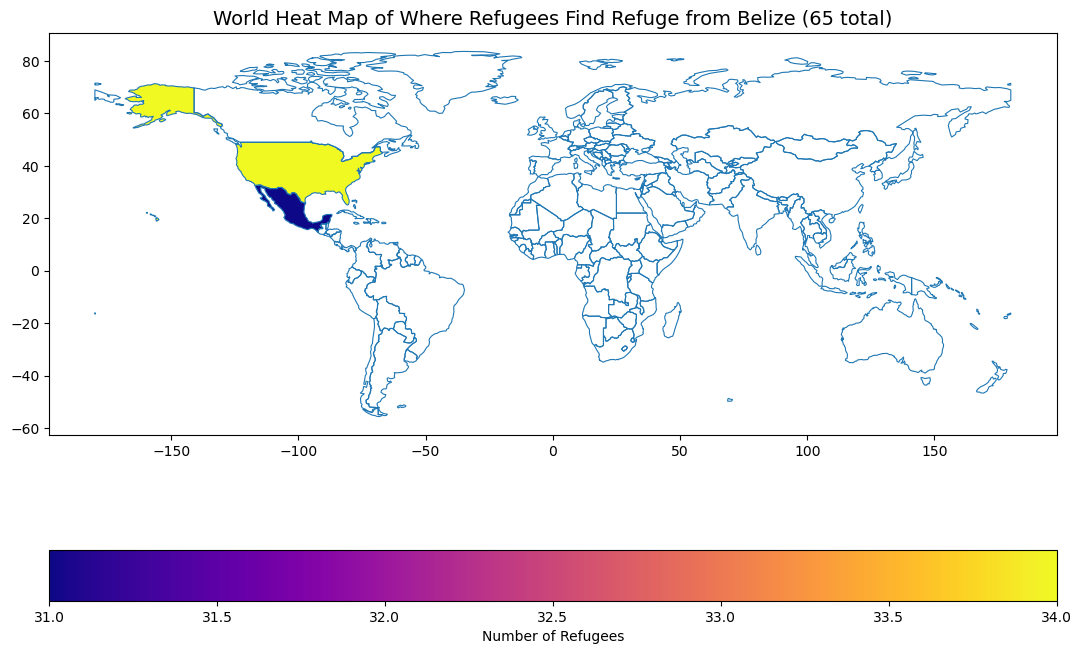

NameError: name 'generate_asylum_dictionary' is not defined

In [25]:
year = 2022        # Select Year to Graph
country = 'Belize' # Select Country Of Origin 

# Plot the yeat map of whichever year (2010-2022), whichever country of origin, 
plot_heat_map(country, generate_refugee_dictionary(data, year), False)
plot_heat_map(country, generate_asylum_dictionary(data, year), True)


## Question 2

---

Which countries have the highest proportion of returned-refugees to refugees?

`get_total_refugees()` gathers the total number of refugees that fled from each country.

`get_total_returned_refugees()` gathers the total number of refugees that were returned to their country of origin.

In [6]:
def get_total_refugees(year):
    subframe = data[data['year'] == year]   #Gets dataframe of specific year
    
    # Gets total refugees who left from their country of origin; country:number
    totalRefugeesFromCOO = {}
    #iters over every column of datafram
    for index, series in subframe.iterrows(): 
        coo_name = series['coo_name']
        refugees = series['refugees']
        if refugees > 0: # removes 0-refugee countries
            # adds/updates refugee count per country
            if coo_name not in totalRefugeesFromCOO:
                totalRefugeesFromCOO[coo_name] = refugees
            else:
                totalRefugeesFromCOO[coo_name] += refugees
    return totalRefugeesFromCOO

def get_total_returned_refugees(year):
    subframe = data[data['year'] == year]   #Gets dataframe of specific year
    # Gets total returned refugees from to country of origin
    totalReturnedRefugeesFromCOO = {}
    for index, series in subframe.iterrows(): 
        coo_name = series['coo_name']
        returnedRefugees = series['returned_refugees']
        
        if returnedRefugees > 0: # removes 0-refugee countries
            # adds/updates returned_refugee count per country
            if coo_name not in totalReturnedRefugeesFromCOO:
                totalReturnedRefugeesFromCOO[coo_name] = returnedRefugees
            else:
                totalReturnedRefugeesFromCOO[coo_name] += returnedRefugees
    return totalReturnedRefugeesFromCOO

#### Plotting helper function

In [49]:
def plot_refugees_returned_ratio(total_refugees, total_refugees_returned, year):
    d = {}
    for key, value in total_returned_refugees.items():
        #avoids divide-by-zero error and just assigns ratio to 1
        if total_refugees[key]>0:
            print(f'{key}: {value}/{total_refugees[key]}')
            ratio = value / total_refugees[key]
        else:
            ratio = 1 
        d[key] = round(ratio, 3)
    
    # sorts dictionary in descending order
    d = dict(sorted(d.items(), key=lambda x:x[1], reverse=True))
    fig, ax = plt.subplots(figsize=(14, 10))
    plt.xticks(rotation=90) #rotates labels
    ax.bar(d.keys(), d.values(),width=.8)
    
    ax.set_title(f'Percentage of Refugees Returned to their Country of Origin in {year}')
    plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.3)
    plt.ylabel("Percentage of Returned Refugees")
    
    plt.show()

### Plots the Ratio of Returned Refugees to Total Refugees (Questionable, Verify Accuracy)

Cote d'Ivoire: 12220/71107
Mali: 4088/154202
Iraq: 5914/264086
Sudan: 39491/627080
Colombia: 1794/340116
Afghanistan: 61381/2666294
Iran (Islamic Rep. of): 10/84950
Russian Federation: 5/67008
Dem. Rep. of the Congo: 8535/541487
Eswatini: 7/213
Namibia: 21/1272
Zimbabwe: 31/21332
Croatia: 111/33452
Rwanda: 5050/286357
Central African Rep.: 21632/471093
Chad: 38/14921
Angola: 4639/11855
Burundi: 16/292750
Uganda: 1191/6311
Somalia: 32343/1123144
Bosnia and Herzegovina: 21/18763
Liberia: 56/9972
Togo: 6/8774
Sri Lanka: 854/121427
Pakistan: 5/297886
Palestinian: 12/98013
Syrian Arab Rep.: 188/4873236
South Sudan: 159/778722
Serbia and Kosovo: S/RES/1244 (1999): 328/38620
Ethiopia: 5/85839
Egypt: 5/17929
Kenya: 1231/7902


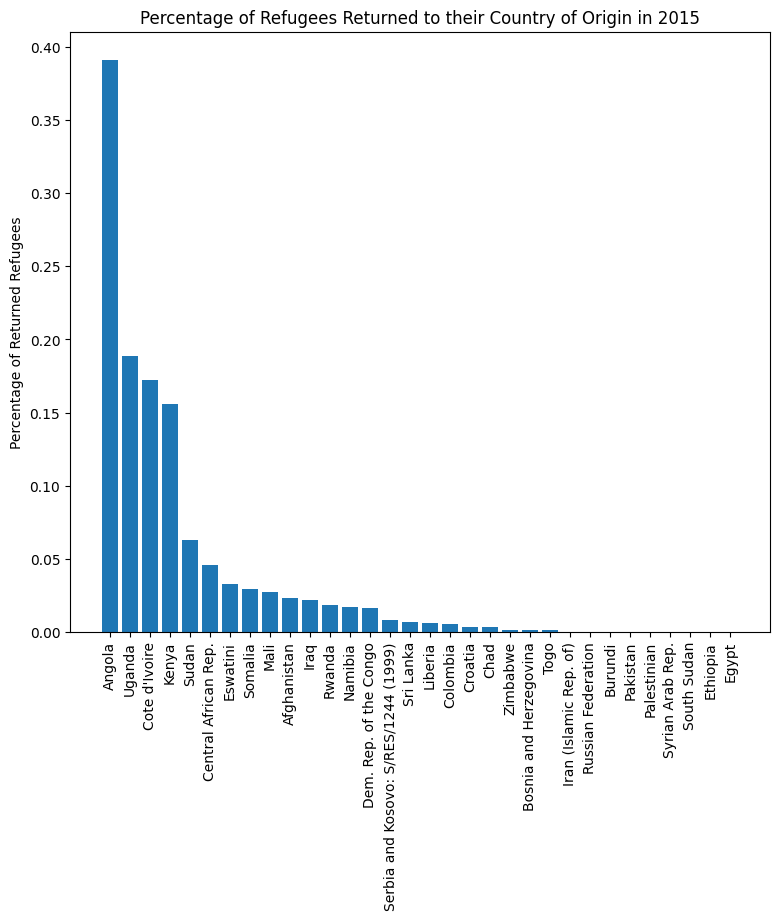

In [55]:
year = 2015  # Change me! (2010-2022) 2016-2018 is interesting...

# Retrieves data
total_refugees = get_total_refugees(year)
total_returned_refugees = get_total_returned_refugees(year)
# Plots Data
plot_refugees_returned_ratio(total_refugees, total_returned_refugees, year)

In [44]:
def generate_stateless_dictionary(data, year):
    subframe = data[data['year'] == int(year)]  # dataframe of specific year
    d_coa = {}  # dictionary of country of origin. { CountryOfAsylum:numStatelessIndividuals }
    for index, series in subframe.iterrows():
        coa = series['coa_name']  # country of asylum string
        stateless = series['stateless']  # number of stateless individuals

        # counts the number of stateless individuals for each COA
        if stateless > 0:
            if coa not in d_coa:  #If countryOfAsylum is not in the dict, add it with current value.
                d_coa[coa] = stateless
            else:  # If it's in the dict, increment dict
                d_coa[coa] += stateless
    return d_coa

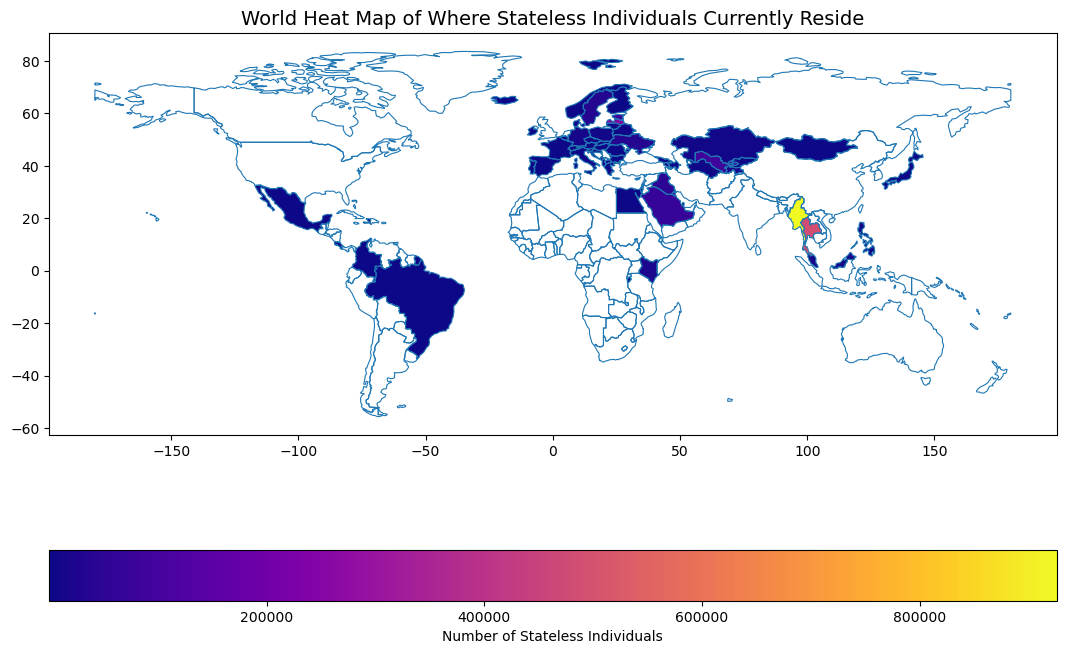

In [45]:
statelessYear = 2016 # year to graph
statelessByCOA = generate_stateless_dictionary(data, statelessYear)

# heat map that visualizes population of stateless refugees in each country

# Load world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name != 'Antarctica')]  # Removes Antartica
# Map the data to the image
world['data'] = world['name'].map(statelessByCOA)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
world.boundary.plot(ax=ax, linewidth=0.8)

world.plot(column='data', cmap='plasma', ax=ax, legend=True, 
                   legend_kwds={'label': "Number of Stateless Individuals", 'orientation': "horizontal"})
ax.set_title(f"World Heat Map of Where Stateless Individuals Currently Reside",fontsize=14)
plt.show()

In [131]:
import pandas as pd
# ------------ CALCULATE REFUGEE AND ASYLUM-SEEKER DATA ------------ #
# determine countries with the top 10 highest numbers of refugees from 2010-2022
totalRefsByCtry = data.groupby(['coo_name'])['refugees'].sum().reset_index()
topTenRefCountries = totalRefsByCtry.nlargest(10, ['refugees'])['coo_name']

# calculate number of refugees per year for the top 10 countries
subsetData = data[data['coo_name'].isin(topTenRefCountries)]
refugeePlotValues = subsetData.groupby(['year', 'coo_name'])['refugees'].sum().reset_index()
#refugeePlotValues

# determine countries with the top 10 highest numbers of asylum-seekers from 2010-2022
totalSkersByCtry = data.groupby(['coo_name'])['asylum_seekers'].sum().reset_index()
topTenSkrCountries = totalSkersByCtry.nlargest(10, ['asylum_seekers'])['coo_name']

# calculate number of asylum-seekers per year for the top 10 countries
subsetData = data[data['coo_name'].isin(topTenSkrCountries)]
seekerPlotValues = subsetData.groupby(['year', 'coo_name'])['asylum_seekers'].sum().reset_index()
#seekerPlotValues

# get list of countries to be used for graph colors
uniqueCountries = (pd.concat([refugeePlotValues['coo_name'], seekerPlotValues['coo_name']])).unique()

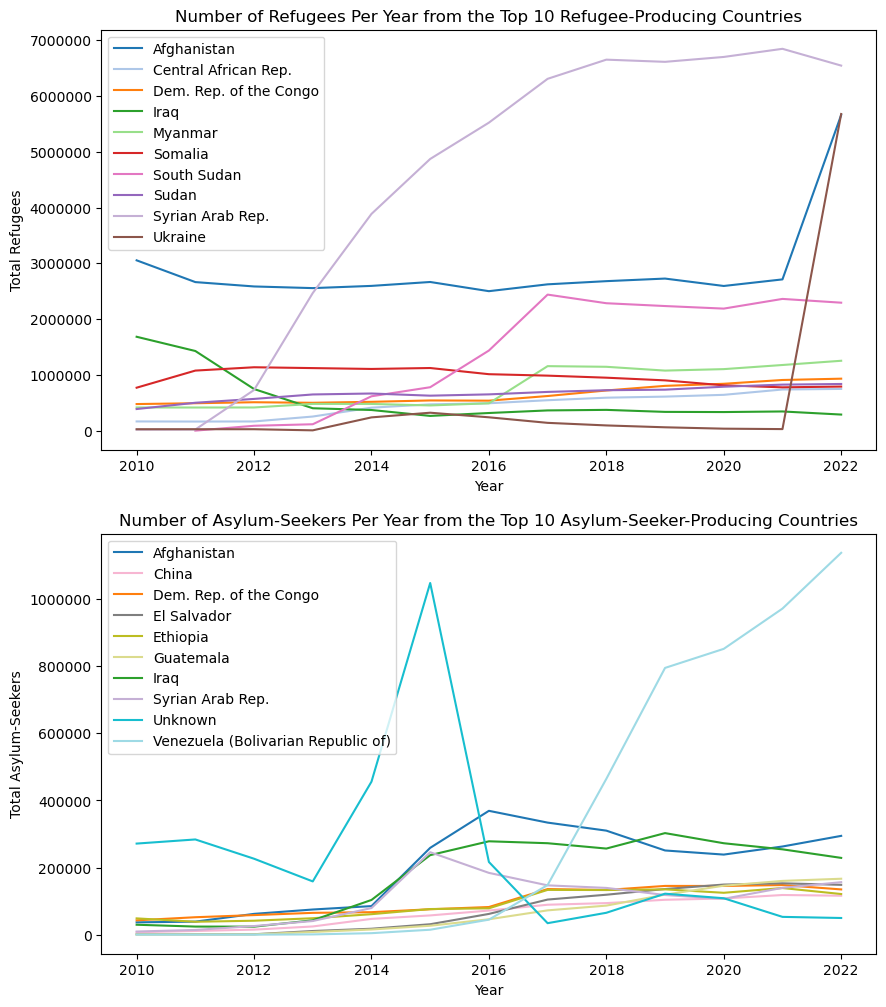

In [136]:
# plot top 10 countries producing refugees overall
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# --------------------------- PLOT DATA --------------------------- #
# Assign colors to countries
colors = plt.cm.tab20(np.linspace(0, 1, len(uniqueCountries)))
color_dict = {country: color for country, color in zip(uniqueCountries, colors)}

# Plot graphs with assigned colors

# REFUGEE DATA
for country, group in refugeePlotValues.groupby('coo_name'):
    axs[0].plot(group['year'], group['refugees'], label=country, color=color_dict[country])

axs[0].ticklabel_format(style='plain')
axs[0].set_title('Number of Refugees Per Year from the Top 10 Refugee-Producing Countries')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Total Refugees')
axs[0].legend(loc='best')

# ASYLUM-SEEKER DATA
for country, group in seekerPlotValues.groupby('coo_name'):
    axs[1].plot(group['year'], group['asylum_seekers'], label=country, color=color_dict[country])
    # Set y-axis tick formatter to ScalarFormatter

axs[1].ticklabel_format(style='plain')
axs[1].set_title('Number of Asylum-Seekers Per Year from the Top 10 Asylum-Seeker-Producing Countries')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Asylum-Seekers')
axs[1].legend(loc='best')

plt.show()